# Burgers equation

This code is modified from the code https://github.com/alexpapados/Physics-Informed-Deep-Learning-Solid-and-Fluid-Mechanics

The paper about this work can ref https://www.researchgate.net/publication/359480166_Discontinuity_Computing_with_Physics-Informed_Neural_Network

In [127]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
torch.manual_seed(124)
np.random.seed(124)

In [128]:
def train(epoch):
    model.train()
    model.it = epoch
    def closure():
        optimizer.zero_grad()                                              
        loss_pde = model.loss_pde(x_int)                                   
        loss_ic = model.loss_ic(x_ic, u_ic)  
        loss = loss_pde + 10*loss_ic                                       

        print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f}')
        model.it = model.it + 1
        outputfile = open('loss_history_burgers.dat','a+')
        print(f'{model.it}  {loss_pde:.6f}  {loss_ic:.6f}  {loss:.6f}',file=outputfile)
        outputfile.close() 
        loss.backward()
        return loss

    loss = optimizer.step(closure)
    loss_value = loss.item() if not isinstance(loss, float) else loss
    print(f'epoch {epoch}: loss {loss_value:.6f}')
    
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

def IC(x):
    N = len(x)
    u_init = np.zeros((x.shape[0]))                                                
    for i in range(N):
        u_init[i] = -np.sin(np.pi*(x[i,1]-1))
    return u_init

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()                                                  
        self.net.add_module('Linear_layer_1', nn.Linear(2, 30))                     
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              

        for num in range(2, 5):                                                     
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(30, 30))       
            self.net.add_module('Tanh_layer_%d' % (num), nn.Tanh())                 
        self.net.add_module('Linear_layer_final', nn.Linear(30, 1))                 

    def forward(self, x):
        return self.net(x)

    def loss_pde(self, x):
        y = self.net(x)                                                
        u = y[:, 0:1]
        
        U = u**2/2

        dU_g = gradients(U, x)[0]                                  
        U_x = dU_g[:, 1:]
        du_g = gradients(u, x)[0]                                 
        u_t,u_x = du_g[:, :1],du_g[:,1:]
        d = 0.1*(abs(u_x)-u_x) + 1
      #  d = 1
        f = (((u_t + U_x)/d)**2).mean() 
         
        return f
    def res_pde(self,x):
        y = self.net(x)
        Res = np.zeros((x.shape[0]))                                  
        
        u = y[:, 0:1]
        U = u**2/2
        dU_g = gradients(U, x)[0]                                 
        U_x = dU_g[:, 1:]
        du_g = gradients(u, x)[0]                                  
        u_t,u_x = du_g[:, :1],du_g[:,1:]
        Res = (u_t + U_x)**2 
        return Res 
    
    def lambda_pde(self,x):
        y = self.net(x)
        Res = np.zeros((x.shape[0]))                                  
        
        u = y[:, 0:1]
        du_g = gradients(u, x)[0]                                  
        u_t,u_x = du_g[:, :1],du_g[:,1:]
        d = 0.1*(abs(u_x)-u_x) + 1
        return  d
        

    def loss_ic(self, x_ic, u_ic):
        y_ic = self.net(x_ic)                                                      
        u_ic_nn = y_ic[:, 0]
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean()
        return loss_ics

In [129]:

device = torch.device('cuda')                                      
num_x = 100                                                        
num_t = 100                                                        
num_i_train = 100                                           
num_f_train = 10000                                            
x = np.linspace(0, 2, num_x)                                   
t = np.linspace(0, 1, num_t)                                   
t_grid, x_grid = np.meshgrid(t, x)                             
T = t_grid.flatten()[:, None]                                  
X = x_grid.flatten()[:, None]                                  

id_ic = np.random.choice(num_x, num_i_train, replace=False)    
id_f = np.random.choice(num_x*num_t, num_f_train, replace=False)

x_ic = x_grid[id_ic, 0][:, None]                               
t_ic = t_grid[id_ic, 0][:, None]                               
x_ic_train = np.hstack((t_ic, x_ic))                               
u_ic_train = IC(x_ic_train)                 

x_int = X[:, 0][id_f, None]                                        
t_int = T[:, 0][id_f, None]                                        
x_int_train = np.hstack((t_int, x_int))                            

x_ic = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
x_int = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)
u_ic = torch.tensor(u_ic_train, dtype=torch.float32).to(device)

model = DNN().to(device)

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print('Start training...')

Start training...


In [ ]:
#optimizer = torch.optim.LBFGS(model.parameters(),lr=0.01,max_iter=20)
epochs = 15000
tic = time.time()
for epoch in range(1, epochs+1):
    train(epoch)
    
toc = time.time()

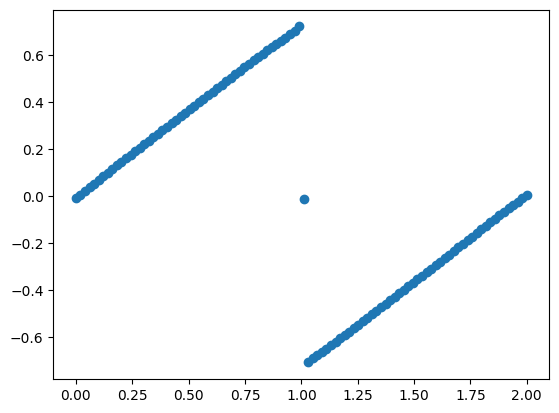

In [131]:

x = np.linspace(0.0, 2.0, 100)                                  
t = np.linspace(1.0, 1.0, 1)                                        
t_grid, x_grid = np.meshgrid(t, x)                              
T = t_grid.flatten()[:, None]                                   
X = x_grid.flatten()[:, None]                                   
x_test = np.hstack((T, X))                                      
x_test = torch.tensor(x_test, requires_grad=True, dtype=torch.float32).to(device)
u_pred = to_numpy(model(x_test))
res = to_numpy(model.res_pde(x_test))
d   = to_numpy(model.lambda_pde(x_test))

#loss = model.loss_pde(x_test)                                 

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.show()

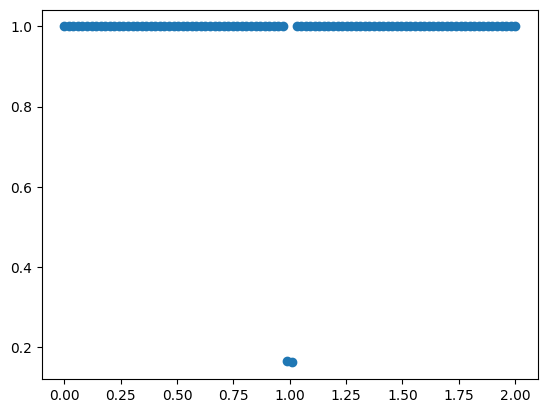

In [78]:
plt.scatter(x[:],1/d[:,0])

plt.show()

In [124]:
new_array = np.array(u_pred[:,0])
file = open("burgers_u_we_11500.dat", "w+")
for i in range(u_pred.shape[0]):
    print(f'{x[i]}  {u_pred[i,0]} ',file=file)
file.close()

In [14]:
new_array = np.array(res[:,0])
file = open("burgers_res_w_5000.dat", "w+")
for i in range(u_pred.shape[0]):
    print(f'{x[i]}  {res[i,0]} ',file=file)
file.close()

In [57]:
file = open("burgers_d_w_14931.dat", "w+")
for i in range(d.shape[0]):
    print(f'{x[i]}  {1/d[i,0]} ',file=file)
file.close()